In [36]:
import networkx as nx
import cirq
import cirq_google
import numpy as np
from matplotlib import pyplot as plt

In [90]:
class Gate:
    def __init__(self, gname, *args):
        self.name = gname
        self.qs = []
        for i in args:
            self.qs.append(i)
        if self.name != "":
            self.gate = getattr(cirq, self.name)

def choose_oneq_gates(gates, depth, num_q):
    #Chooses one one-qubit gate from given for each step in range(depth)
    answer = []
    probs = [[len(gates) for i in range(len(gates))] for j in range(num_q)]
    for i in range(depth):
        ans = []
        for j in range(num_q):
            gate = np.random.choice(gates, p = np.array([1. / i for i in probs[j]]) / sum([1. / i for i in probs[j]]))
            ans.append(gate)
            probs[j][gates.index(gate)] += len(gates)
        answer.append(ans)
#         gate = np.random.choice(gates, p = np.array([1. / i for i in probs]) / sum([1. / i for i in probs]))
#         probs[gates.index(gate)] += len(gates)
#         ans.append(gate)
    return answer

def choose_qubits_for_CZ(depth, num_q):
    #Chooses qubits to apply CZ to for each step in range(depth)
    ans = []
    odds = [i for i in range(num_q - 1) if i % 2 == 1]
    evens = [i for i in range(num_q - 1) if i % 2 == 0]
    vrs = [odds, evens]
    probs = [2, 2]
    for i in range(depth):
        qs = np.random.choice([i for i in range(len(probs))], p = np.array([1. / i for i in probs]) / sum([1. / i for i in probs]))
        probs[qs] += len(vrs)
        ans.append(np.array(vrs[qs]))
    return ans

### Generate Gate Sequence

In [91]:
num_q = 5
depth = 4

oneq_gates = ["T", "rx", "ry"]
seq_oneq_gates = choose_oneq_gates(oneq_gates, depth, num_q)
seq_cz_qubits = choose_qubits_for_CZ(depth, num_q)

gates = []
nodes = []

for i in range(num_q):
    gates.append(Gate("H", i))
    nodes.append((i, {"subset" : 0}))

cnt = num_q
for i in range(depth):
    for v in range(num_q):
        if v in seq_cz_qubits[i]:
            gates.append(Gate("CZ", v, v + 1))
            nodes.append((cnt, {"subset" : 2 * i + 1}))
            cnt += 1
        elif v not in seq_cz_qubits[i] and v not in seq_cz_qubits[i] + 1:
            gates.append(Gate(""))
            nodes.append((cnt, {"subset" : 2 * i + 1}))
            cnt += 1

    for j in range(num_q):
        gates.append(Gate(seq_oneq_gates[i][j], j))
        nodes.append((cnt, {"subset" : 2 * i + 2}))
        cnt += 1

In [92]:
for g in gates:
    print(g.name, g.qs)

H [0]
H [1]
H [2]
H [3]
H [4]
 []
CZ [1, 2]
CZ [3, 4]
T [0]
T [1]
T [2]
T [3]
T [4]
CZ [0, 1]
CZ [2, 3]
 []
rx [0]
rx [1]
ry [2]
T [3]
ry [4]
 []
CZ [1, 2]
CZ [3, 4]
ry [0]
ry [1]
rx [2]
T [3]
ry [4]
 []
CZ [1, 2]
CZ [3, 4]
ry [0]
ry [1]
T [2]
ry [3]
rx [4]


### Create Graph

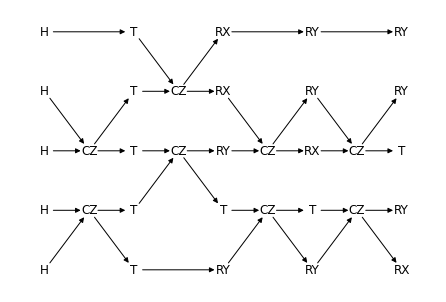

In [93]:
G = nx.DiGraph()
G.add_nodes_from(nodes)

cur_gate = np.array([i for i in range(num_q)])
cur = num_q
for gate in gates[num_q:]:
    for i in gate.qs:
        G.add_edge(cur_gate[i], cur)
        cur_gate[i] = cur
    cur += 1
    
pos = nx.multipartite_layout(G)
labeldict = {}
for i in range(len(gates)):
    labeldict[i] = gates[i].name.upper()
nx.draw(G, pos, labels = labeldict, with_labels = True, node_color = 'none')

### Simulate on LineQubit

In [94]:
q_line = cirq.LineQubit.range(num_q)
line_circuit = cirq.Circuit()

for gate in gates:        
    if len(gate.qs) == 1 and gate.name[0] != 'r':
        line_circuit.append(gate.gate(q_line[gate.qs[0]]))
    elif len(gate.qs) == 1:
        line_circuit.append(gate.gate(np.pi / 2)(q_line[gate.qs[0]]))
    elif len(gate.qs) == 2:
        line_circuit.append(gate.gate(q_line[gate.qs[0]], q_line[gate.qs[1]]))
print(line_circuit)

0: ───H───T───────@──────────Rx(0.5π)───Ry(0.5π)───Ry(0.5π)──────────────────
                  │
1: ───H───@───T───@──────────Rx(0.5π)───@──────────Ry(0.5π)───@───Ry(0.5π)───
          │                             │                     │
2: ───H───@───T───@──────────Ry(0.5π)───@──────────Rx(0.5π)───@───T──────────
                  │
3: ───H───@───T───@──────────T──────────@──────────T──────────@───Ry(0.5π)───
          │                             │                     │
4: ───H───@───T───Ry(0.5π)──────────────@──────────Ry(0.5π)───@───Rx(0.5π)───


In [95]:
sim = cirq.Simulator()
results_line = sim.simulate(line_circuit)
print(results_line)

measurements: (no measurements)
output vector: [-0.16919413-0.10669415j  0.01830584+0.04419417j -0.22097081-0.10669416j
  0.1433058 +0.04419416j -0.1325825 -0.10669414j  0.1433058 -0.04419413j
 -0.04419417-0.19508249j -0.07008252+0.1691941j   0.16919416-0.14330578j
 -0.19508246+0.13258249j  0.04419414-0.07008249j  0.10669415-0.04419417j
 -0.08080582+0.01830582j  0.19508246+0.08080581j  0.08080582+0.10669415j
 -0.19508244-0.13258249j -0.07008249+0.1325825j   0.08080579-0.23169407j
 -0.01830581-0.04419418j -0.04419416+0.19508246j  0.07008251-0.16919412j
 -0.16919412+0.10669414j -0.0700825 -0.1325825j   0.16919412+0.01830582j
 -0.10669413+0.04419417j -0.08080581-0.01830582j -0.23169412+0.04419414j
  0.22097081-0.01830581j -0.2316941 -0.04419414j  0.13258246-0.01830582j
 -0.19508249-0.08080577j  0.04419419+0.07008249j]


### Simulate with Swaps

In [96]:
q_cross = []
#В начале в центре первый кубит (можем применять CZ на пары (0,1) и (1,2)), при необходимости меняем его и третий (получаем оставшиеся пары (2,3) и (3,4))
q_cross.append(cirq.GridQubit(0, 1))    #qubit 0
q_cross.append(cirq.GridQubit(1, 1))    #qubit 1
q_cross.append(cirq.GridQubit(1, 0))    #qubit 2
q_cross.append(cirq.GridQubit(1, 2))    #qubit 3
q_cross.append(cirq.GridQubit(2, 1))    #qubit 4
qubits = [i for i in range(num_q)]

def crs(q):
    return qubits.index(q)
def swap(qubits):
    sw = qubits[1]
    qubits[1] = qubits[3]
    qubits[3] = sw    

cross_circuit = cirq.Circuit()

for gate in gates:        
    if len(gate.qs) == 1 and gate.name[0] != 'r':
        cross_circuit.append(gate.gate(q_cross[crs(gate.qs[0])]))
    elif len(gate.qs) == 1:
        cross_circuit.append(gate.gate(np.pi / 2)(q_cross[crs(gate.qs[0])]))
    elif len(gate.qs) == 2:
        if (3 in gate.qs and qubits[1] == 1) or (1 in gate.qs and qubits[1] == 3):
            qb = crs(gate.qs[1 - gate.qs.index(4 - qubits[1])])
            cross_circuit.append(cirq.SWAP(q_cross[crs(1)], q_cross[crs(3)]))
            swap(qubits)
        else:
            qb = crs(gate.qs[1 - gate.qs.index(qubits[1])])
        cross_circuit.append(gate.gate(q_cross[1], q_cross[qb]))
if qubits[1] == 3:
    cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[3]))
cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[2]))
print(cross_circuit)

                       ┌──┐                                                                          ┌─────────┐                          ┌─────────┐
(0, 1): ───H───T─────────────────────────────@───Rx(0.5π)───Ry(0.5π)───Ry(0.5π)────────────────────────────────────────────────────────────────────────────────────────────
                                             │
(1, 0): ───H───@───T─────────────────────────┼──────────────@──────────Ry(0.5π)───────@───Rx(0.5π)────────────────────────────────@───T────────────────────────────────×───
               │                             │              │                         │                                           │                                    │
(1, 1): ───H───@───×────@─────T───×──────────@───×──────────@──────────T──────────×───@───×───────────@────────────T──────────×───@───×────@────────────Ry(0.5π)───×───×───
                   │    │         │              │                                │       │           │               

In [97]:
print(line_circuit)

0: ───H───T───────@──────────Rx(0.5π)───Ry(0.5π)───Ry(0.5π)──────────────────
                  │
1: ───H───@───T───@──────────Rx(0.5π)───@──────────Ry(0.5π)───@───Ry(0.5π)───
          │                             │                     │
2: ───H───@───T───@──────────Ry(0.5π)───@──────────Rx(0.5π)───@───T──────────
                  │
3: ───H───@───T───@──────────T──────────@──────────T──────────@───Ry(0.5π)───
          │                             │                     │
4: ───H───@───T───Ry(0.5π)──────────────@──────────Ry(0.5π)───@───Rx(0.5π)───


In [98]:
sim_cross = cirq.Simulator()
results_cross = sim_cross.simulate(cross_circuit)
print(results_cross)

measurements: (no measurements)
output vector: [-0.16919407-0.10669412j  0.01830581+0.04419413j -0.22097075-0.10669412j
  0.14330573+0.04419414j -0.13258246-0.10669413j  0.14330575-0.04419415j
 -0.04419417-0.1950824j  -0.07008248+0.16919407j  0.16919409-0.14330578j
 -0.19508243+0.13258247j  0.04419415-0.07008249j  0.10669412-0.04419415j
 -0.08080577+0.01830582j  0.19508243+0.08080577j  0.08080578+0.10669412j
 -0.19508241-0.13258244j -0.0700825 +0.13258244j  0.08080578-0.23169406j
 -0.01830582-0.04419414j -0.04419415+0.19508243j  0.07008249-0.16919406j
 -0.16919409+0.10669412j -0.07008247-0.13258244j  0.16919409+0.01830582j
 -0.10669413+0.04419415j -0.08080578-0.0183058j  -0.23169404+0.04419412j
  0.22097075-0.01830583j -0.23169404-0.04419415j  0.13258244-0.01830583j
 -0.19508241-0.08080579j  0.04419414+0.07008247j]


### Results comparison

In [99]:
np.round(results_line.final_state_vector - results_cross.final_state_vector, 3)
#Результаты одинаковые

array([-0.-0.j,  0.+0.j, -0.-0.j,  0.+0.j, -0.-0.j,  0.+0.j,  0.-0.j,
       -0.+0.j,  0.+0.j, -0.+0.j, -0.-0.j,  0.-0.j, -0.-0.j,  0.+0.j,
        0.+0.j, -0.-0.j,  0.+0.j,  0.-0.j,  0.-0.j, -0.+0.j,  0.-0.j,
       -0.+0.j, -0.-0.j,  0.-0.j,  0.+0.j, -0.-0.j, -0.+0.j,  0.+0.j,
       -0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j], dtype=complex64)